# Isolation forest for outlier detection

In [1]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)

Windows-10-10.0.19045-SP0
Python 3.10.5 (tags/v3.10.5:f377153, Jun  6 2022, 16:14:13) [MSC v.1929 64 bit (AMD64)]


## Load data

In [2]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme(style='darkgrid', palette='Set1')

from sklearn.ensemble import IsolationForest, HistGradientBoostingRegressor
from sklearn.model_selection import  KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
class cfg:
    seed = 42
    nfolds = 5
    njobs = 2

In [4]:
# load data
train = pd.read_csv('../data/raw/train.csv', index_col=0).reset_index(drop=True)
train_comb = pd.read_csv('../data/extra/train_comb.csv')
train_orig = pd.read_csv('../data/extra/train_orig.csv')

train.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980
1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946
2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576
3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336
4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500


In [5]:
# quick info
TARGET = 'MedHouseVal'
FEATURES = [c for c in train.columns if c not in [TARGET]]

print(f'Target: {TARGET}\nFeatures: {FEATURES}')
print('Train set shape:', train.shape)
print('Combined train set shape:', train_comb.shape)

x = train.drop(TARGET, axis=1)

Target: MedHouseVal
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Train set shape: (37137, 9)
Combined train set shape: (57777, 10)


## Isolation Forest

In [6]:
# isolation forest for outlier detection
iso = IsolationForest(
    n_estimators=1000,
    max_samples=0.3,
    contamination='auto',
    verbose=0,
    n_jobs=cfg.njobs,
    random_state=cfg.seed
)

_ = iso.fit(x)

In [7]:
# predict scores and outliers
scores = iso.score_samples(x)
isin = iso.predict(x)

print(f'The amount of predicted outliers in the train set is {sum(isin==-1)} ({sum(isin==-1)/train.shape[0]:.2%})')

The amount of predicted outliers in the train set is 458 (1.23%)


<AxesSubplot: ylabel='Count'>

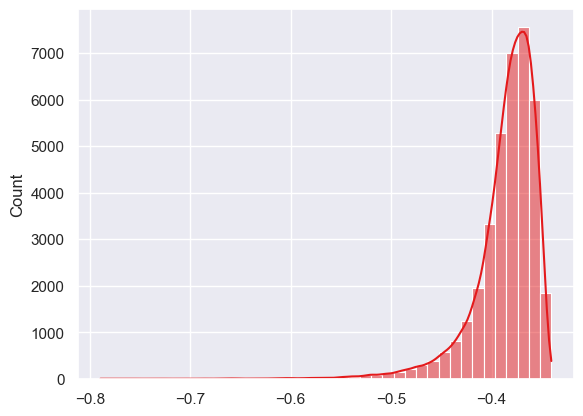

In [8]:
sns.histplot(scores, bins=40, kde=True)

<AxesSubplot: ylabel='MedHouseVal'>

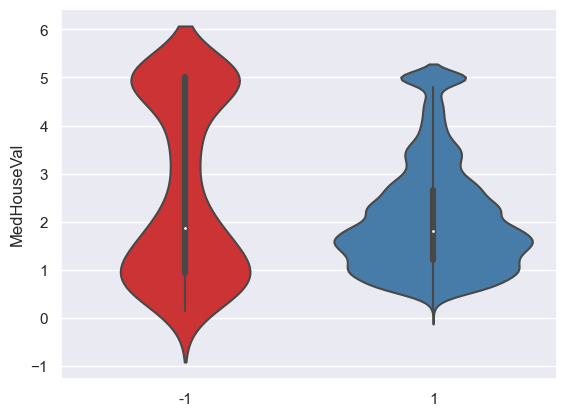

In [9]:
sns.violinplot(data=train, x=isin, y=TARGET)

In [10]:
# correlation with response
c = np.corrcoef(train[TARGET], scores)[0][1]
print(f'Target correlation with anomaly scores on train test is {c:.4f}')

Target correlation with anomaly scores on train test is -0.0718


In [11]:
# other vars
train[FEATURES].corrwith(train[TARGET])

MedInc        0.701925
HouseAge      0.103210
AveRooms      0.366727
AveBedrms    -0.067487
Population   -0.038479
AveOccup     -0.048475
Latitude     -0.116499
Longitude    -0.056742
dtype: float64

## Does the prediction improve?

In [12]:
# split synthetic train data
x, x_val, y, y_val = train_test_split(
    train.drop(columns=TARGET), train[TARGET],
    test_size=0.25,
    random_state=cfg.seed
)

# define cv
cv = KFold(n_splits=cfg.nfolds, shuffle=True, random_state=cfg.seed)

In [13]:
# try different combinations
results = {
    'baseline':[],
    'no_outliers':[],
    'with_anomaly_score':[],
    'combined_data':[],
    'no_outliers_combined_data':[],
    'with_anomaly_score_combined_data':[]}

for fold, (train_idx, val_idx) in enumerate(cv.split(x, y)):

    print(f'Doing fold {fold+1}/{cfg.nfolds}...')

    # split data
    x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # baseline
    print('\tBaseline model...')
    model = HistGradientBoostingRegressor(random_state=cfg.seed)
    model.fit(x_train, y_train)
    results['baseline'].append(mean_squared_error(y_val, model.predict(x_val)))

    # isolation forest
    print('\tFit isolation forest...')
    iso_fitted = iso.fit(x_train)
    scores = iso.score_samples(x_train)
    scores_val = iso.score_samples(x_val)
    isin = iso.predict(x_train)
    #isin_val = iso.predict(x_val)

    # without outliers
    print('\tModel without outliers...')
    model.fit(x_train.iloc[isin==1], y_train.iloc[isin==1])
    results['no_outliers'].append(mean_squared_error(y_val, model.predict(x_val)))

    # with anomaly score
    print('\tModel with anomaly score...')
    x2, x2_val = x_train.copy(), x_val.copy()
    x2['AnomalyScore'], x2_val['AnomalyScore'] = scores, scores_val
    model.fit(x2, y_train)
    results['with_anomaly_score'].append(mean_squared_error(y_val, model.predict(x2_val)))

    # with original data added
    x3 = pd.concat([x_train, train_orig[FEATURES]], axis=0)
    x3_val = x_val.copy()
    x3['IsSynthetic'] = [1.0]*len(x_train) + [0.0]*len(train_orig)
    x3_val['IsSynthetic'] = 1.0
    y3 = pd.concat([y_train, train_orig[TARGET]], axis=0) 
    
    print('\tBaseline model with original data added to the train set...')
    model = HistGradientBoostingRegressor(random_state=cfg.seed)
    model.fit(x3, y3)
    results['combined_data'].append(mean_squared_error(y_val, model.predict(x3_val)))

    # isolation forest
    print('\tFit isolation forest on combined data...')
    iso_fitted = iso.fit(x3.loc[x3['IsSynthetic']==1])
    scores = iso.score_samples(x3)
    scores_val = iso.score_samples(x3_val)
    isin = iso.predict(x3)

    # without outliers
    print('\tModel without outliers on combined data...')
    model.fit(x3.iloc[isin==1], y3.iloc[isin==1])
    results['no_outliers_combined_data'].append(mean_squared_error(y_val, model.predict(x3_val)))

    # with anomaly score
    print('\tModel with anomaly score on combined data...')
    x3['AnomalyScore'], x3_val['AnomalyScore'] = scores, scores_val
    model.fit(x3, y3)
    results['with_anomaly_score_combined_data'].append(mean_squared_error(y_val, model.predict(x3_val)))

Doing fold 1/5...
	Baseline model...
	Fit isolation forest...
	Model without outliers...
	Model with anomaly score...
	Baseline model with original data added to the train set...
	Fit isolation forest on combined data...
	Model without outliers on combined data...
	Model with anomaly score on combined data...
Doing fold 2/5...
	Baseline model...
	Fit isolation forest...
	Model without outliers...
	Model with anomaly score...
	Baseline model with original data added to the train set...
	Fit isolation forest on combined data...
	Model without outliers on combined data...
	Model with anomaly score on combined data...
Doing fold 3/5...
	Baseline model...
	Fit isolation forest...
	Model without outliers...
	Model with anomaly score...
	Baseline model with original data added to the train set...
	Fit isolation forest on combined data...
	Model without outliers on combined data...
	Model with anomaly score on combined data...
Doing fold 4/5...
	Baseline model...
	Fit isolation forest...
	Mode

In [14]:
# obtain cv results
tmp = pd.DataFrame(results)**(1/2)
res_df = pd.DataFrame({
    'cv_mean': tmp.mean(axis=0), 
    'cv_sd': tmp.std(axis=0)}
)

res_df.sort_values(by='cv_mean')

,cv_mean,cv_sd
combined_data,0.564202,0.005306
with_anomaly_score_combined_data,0.564234,0.005671
no_outliers_combined_data,0.564260,0.005935
no_outliers,0.568222,0.007273
baseline,0.568225,0.006415
with_anomaly_score,0.569068,0.005550
